Shape of dataset: (18368, 12)
Columns: ['ID', 'SystemCodeNumber', 'Capacity', 'Latitude', 'Longitude', 'Occupancy', 'VehicleType', 'TrafficConditionNearby', 'QueueLength', 'IsSpecialDay', 'LastUpdatedDate', 'LastUpdatedTime']
ID                          int64
SystemCodeNumber           object
Capacity                    int64
Latitude                  float64
Longitude                 float64
Occupancy                   int64
VehicleType                object
TrafficConditionNearby     object
QueueLength                 int64
IsSpecialDay                int64
LastUpdatedDate            object
LastUpdatedTime            object
dtype: object
Missing values:
 ID                        0
SystemCodeNumber          0
Capacity                  0
Latitude                  0
Longitude                 0
Occupancy                 0
VehicleType               0
TrafficConditionNearby    0
QueueLength               0
IsSpecialDay              0
LastUpdatedDate           0
LastUpdatedTime           0

/tmp/ipython-input-2-2749593881.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[timestamp_col] = pd.to_datetime(df[timestamp_col])


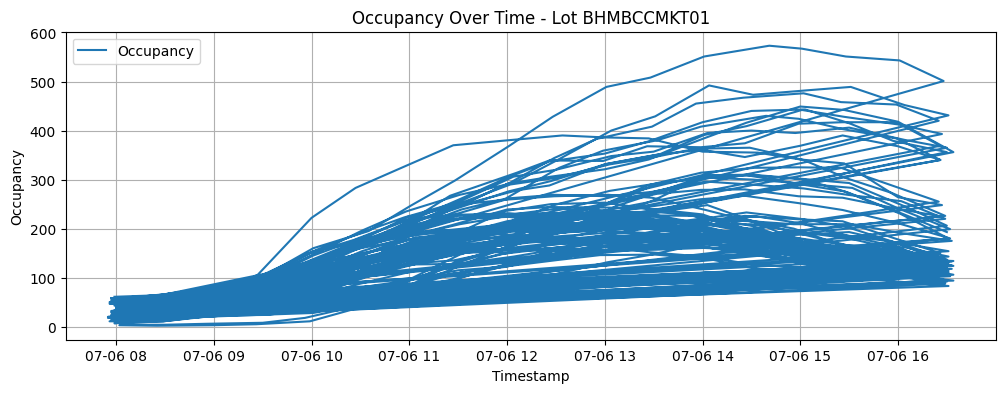

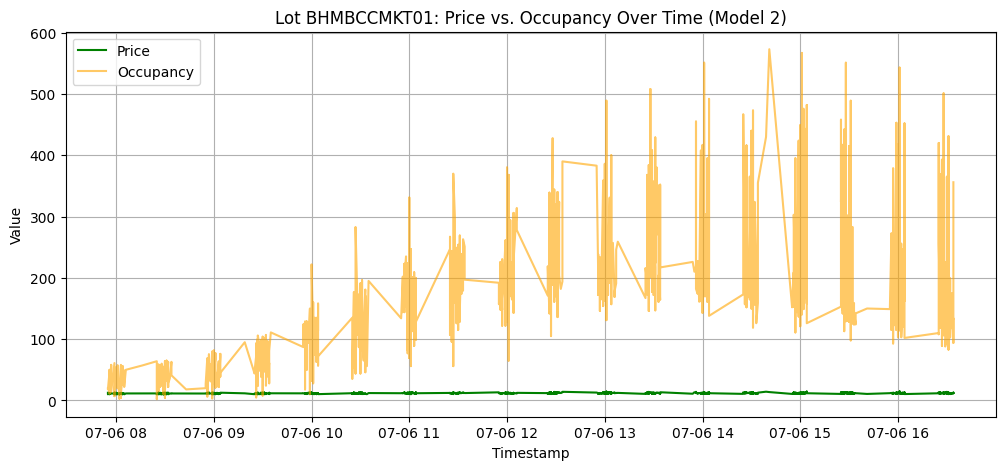


Model 2 (Demand-Based) complete. Ready for Model 3 or visualization.


In [2]:
# Dynamic Pricing for Urban Parking Lots - Model 2 (Demand-Based Model)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# === Load Data ===
if not os.path.exists("dataset.csv"):
    raise FileNotFoundError("dataset.csv not found. Please upload it to your runtime environment.")

df = pd.read_csv("dataset.csv")

# === EDA ===
print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())
print(df.dtypes)
print("Missing values:\n", df.isnull().sum())

# Use actual timestamp column name
timestamp_col = [col for col in df.columns if 'time' in col.lower()][0]
df[timestamp_col] = pd.to_datetime(df[timestamp_col])

# Detect lot_id column
lot_id_col = next((col for col in df.columns if col.lower() in ['lot_id', 'systemcodenumber', 'parkinglotid']), None)
if lot_id_col is None:
    raise KeyError("Column for lot ID not found.")

# Detect occupancy column
occupancy_col = next((col for col in df.columns if col.lower() in ['occupancy', 'current_occupancy']), None)
if occupancy_col is None:
    raise KeyError("Column for occupancy not found.")

# Detect capacity column
capacity_col = next((col for col in df.columns if col.lower() in ['capacity', 'total_capacity']), None)
if capacity_col is None:
    raise KeyError("Column for capacity not found.")

# Optional columns
queue_col = next((col for col in df.columns if col.lower() in ['queue_length', 'queue']), None)
traffic_col = next((col for col in df.columns if col.lower() in ['traffic', 'traffic_level']), None)
special_day_col = next((col for col in df.columns if col.lower() in ['is_special_day', 'special_day', 'holiday_flag']), None)
vehicle_col = next((col for col in df.columns if col.lower() in ['vehicle_type', 'vehicletype']), None)

# Summary info
date_range = (df[timestamp_col].min(), df[timestamp_col].max())
num_lots = df[lot_id_col].nunique()
print(f"Data from {date_range[0]} to {date_range[1]}")
print(f"Total unique parking lots: {num_lots}")

# Plot occupancy for one lot
def plot_occupancy(df, lot_id):
    df_sample = df[df[lot_id_col] == lot_id]
    plt.figure(figsize=(12, 4))
    plt.plot(df_sample[timestamp_col], df_sample[occupancy_col], label='Occupancy')
    plt.title(f'Occupancy Over Time - Lot {lot_id}')
    plt.xlabel('Timestamp')
    plt.ylabel('Occupancy')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_occupancy(df, df[lot_id_col].unique()[0])

# === Model 2: Demand-Based Dynamic Pricing ===
def demand_based_price_model(df, base_price=10.0, alpha=1.0, beta=0.5, gamma=0.3, delta=2.0, epsilon_map=None, lambd=0.5, min_price=5.0, max_price=20.0):
    df = df.copy()
    df = df.sort_values(by=[lot_id_col, timestamp_col])
    df['demand'] = 0.0
    df['price'] = 0.0

    if epsilon_map is None:
        epsilon_map = {'car': 1.0, 'bike': 0.5, 'truck': 1.5}

    demands = []
    prices = []

    for _, row in df.iterrows():
        occ = row[occupancy_col]
        cap = row[capacity_col]
        queue = row[queue_col] if queue_col and queue_col in row else 0
        traffic = row[traffic_col] if traffic_col and traffic_col in row else 0
        special_day = row[special_day_col] if special_day_col and special_day_col in row else 0
        vehicle = row[vehicle_col] if vehicle_col and vehicle_col in row else 'car'

        normalized_occupancy = 0.0 if cap == 0 else occ / cap
        epsilon = epsilon_map.get(vehicle, 1.0)
        demand = alpha * normalized_occupancy + beta * queue - gamma * traffic + delta * special_day + epsilon
        demands.append(demand)

    norm_demand = (np.array(demands) - np.min(demands)) / (np.max(demands) - np.min(demands) + 1e-5)

    for nd in norm_demand:
        price = base_price * (1 + lambd * nd)
        price = max(min_price, min(max_price, price))
        prices.append(price)

    df['demand'] = demands
    df['price'] = prices
    return df

# Run Model 2
df_model2 = demand_based_price_model(df)

# Plot price vs occupancy for one lot
lot_id = df[lot_id_col].unique()[0]
df_lot = df_model2[df_model2[lot_id_col] == lot_id]

plt.figure(figsize=(12, 5))
plt.plot(df_lot[timestamp_col], df_lot['price'], label='Price', color='green')
plt.plot(df_lot[timestamp_col], df_lot[occupancy_col], label='Occupancy', color='orange', alpha=0.6)
plt.title(f'Lot {lot_id}: Price vs. Occupancy Over Time (Model 2)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print("\nModel 2 (Demand-Based) complete. Ready for Model 3 or visualization.")


